<a href="https://colab.research.google.com/github/kaustubhhatkar/DataScience_and_MachineLearning/blob/master/KerasOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import re
import zipfile

# Path to the zip file (replace 'your_zip_file.zip' with the actual file name)
zip_file_path = '/content/test_data.zip'

# Path to the folder where you want to extract the contents
extract_folder = '/content/test_data'

# Create the extract folder if it doesn't exist
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"File {zip_file_path} has been successfully unzipped to {extract_folder}.")

File /content/test_data.zip has been successfully unzipped to /content/test_data.


In [40]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
import keras
from keras import layers


In [ ]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  5261k      0  0:00:01  0:00:01 --:--:-- 15.6M


In [114]:
# Path to the data directory
data_dir = Path("./test_data")
pattern = re.compile(r'_([0-9]+)_')

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

labels=[]


for old_name in images:
        # Search for the pattern in the file name
        match = pattern.search(old_name)

        # If a match is found, extract the captured substring
        if match:

            labels.append(match.group(1))
            # print(f"Renamed: {old_name} to {match.group(1)}")


print("Images :",images)
print("Labels :",labels)


characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 1

# Desired image dimensions
img_width = 200
img_height = 50

# img_width = 128
# img_height = 128
# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print(images)


Images : ['test_data/combined_Kaustubh-1_0714_2.png', 'test_data/combined_Kaustubh-1_07361_5.png', 'test_data/combined_Kaustubh-1_0842_13.png', 'test_data/combined_Kaustubh-1_0_11.png', 'test_data/combined_Kaustubh-1_0_16.png', 'test_data/combined_Kaustubh-1_0_9.png', 'test_data/combined_Kaustubh-1_106_11.png', 'test_data/combined_Kaustubh-1_109_10.png', 'test_data/combined_Kaustubh-1_15264_2.png', 'test_data/combined_Kaustubh-1_15_22.png', 'test_data/combined_Kaustubh-1_1602_16.png', 'test_data/combined_Kaustubh-1_1726_19.png', 'test_data/combined_Kaustubh-1_18452_9.png', 'test_data/combined_Kaustubh-1_1932_23.png', 'test_data/combined_Kaustubh-1_19_9.png', 'test_data/combined_Kaustubh-1_1_14.png', 'test_data/combined_Kaustubh-1_1_18.png', 'test_data/combined_Kaustubh-1_2015_21.png', 'test_data/combined_Kaustubh-1_20_6.png', 'test_data/combined_Kaustubh-1_234_3.png', 'test_data/combined_Kaustubh-1_2359_1.png', 'test_data/combined_Kaustubh-1_2378_14.png', 'test_data/combined_Kaustubh-1

##Preprocessing

In [118]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
print("char_to_num :",char_to_num)
# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.8, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
#x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    #print("Image Path:", img_path.numpy().decode("utf-8"))
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    #img = tf.io.decode_png(img, channels=1)
    img = tf.io.decode_png(img, channels=1)  # Assuming the image is in PNG format with 3 channels (RGB)
    # img = tf.image.rgb_to_grayscale(img)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    #tf.print("Image",img)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    #tf.print("Label",label)
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

char_to_num : <keras.src.layers.preprocessing.string_lookup.StringLookup object at 0x796c233d25c0>


##Create Dataset objects


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size,drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size,drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [105]:
print(images)

['test_data/combined_Kaustubh-1_0714_2.png', 'test_data/combined_Kaustubh-1_07361_5.png', 'test_data/combined_Kaustubh-1_0842_13.png', 'test_data/combined_Kaustubh-1_0_11.png', 'test_data/combined_Kaustubh-1_0_16.png', 'test_data/combined_Kaustubh-1_0_9.png', 'test_data/combined_Kaustubh-1_106_11.png', 'test_data/combined_Kaustubh-1_109_10.png', 'test_data/combined_Kaustubh-1_15264_2.png', 'test_data/combined_Kaustubh-1_15_22.png', 'test_data/combined_Kaustubh-1_1602_16.png', 'test_data/combined_Kaustubh-1_1726_19.png', 'test_data/combined_Kaustubh-1_18452_9.png', 'test_data/combined_Kaustubh-1_1932_23.png', 'test_data/combined_Kaustubh-1_19_9.png', 'test_data/combined_Kaustubh-1_1_14.png', 'test_data/combined_Kaustubh-1_1_18.png', 'test_data/combined_Kaustubh-1_2015_21.png', 'test_data/combined_Kaustubh-1_20_6.png', 'test_data/combined_Kaustubh-1_234_3.png', 'test_data/combined_Kaustubh-1_2359_1.png', 'test_data/combined_Kaustubh-1_2378_14.png', 'test_data/combined_Kaustubh-1_25974_1.

In [106]:
print(labels)

['0714', '07361', '0842', '0', '0', '0', '106', '109', '15264', '15', '1602', '1726', '18452', '1932', '19', '1', '1', '2015', '20', '234', '2359', '2378', '25974', '259', '2760', '278', '27', '2869', '29384', '2', '2', '305', '3164', '3209', '354', '356', '35', '36', '37', '3', '3', '3', '3', '40', '41723', '418', '41', '42', '43', '453', '45', '4', '4', '52', '52', '53617', '549', '54', '57', '581', '5', '5', '6170', '6192', '621', '632', '6520', '6713', '6719', '6745', '683', '6913', '693', '69', '6', '6', '70', '715', '739', '75326', '760', '760', '7639', '763', '768', '784', '78', '7948', '7', '7', '7', '7', '83', '85', '86', '8751', '8', '8', '8', '90', '90', '91', '924', '94251', '9682', '9702', '9715', '971', '97652', '9', '02', '02', '031', '03258', '05', '06', '06', '07', '08625', '086', '0', '0', '0', '10', '158', '158', '163', '1645', '172', '17496', '17', '187', '1908', '198', '1', '1', '1', '1', '2104', '21748', '240', '246', '27', '28', '2', '2', '2', '2', '2', '2', '2',

In [119]:
#onlyfor testing data
testing_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
testing_dataset = (
    testing_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size,drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [ ]:
for batch in testing_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    print("Batch Size:", len(images))

    # Print the shape of each image and label in the batch
    for i in range(len(images)):
        print(f"Image {i} Shape:", images[i].shape)
        print(f"Label {i} Shape:", labels[i].shape)

    print("Label Shapes in the Batch:", [label.shape for label in labels])


In [ ]:
for image, label in testing_dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

In [ ]:
for batch in testing_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    print("Batch Size:", len(images))
    print("Image Shape:", images.shape)
    print("Label Shape:", labels.shape)


##Visualize the data

Image [[[0.545098066]
  [0.556862772]
  [0.56078434]
  ...
  [0.674509823]
  [0.678431392]
  [0.674509823]]

 [[0.552941203]
  [0.564705908]
  [0.556862772]
  ...
  [0.670588255]
  [0.670588255]
  [0.674509823]]

 [[0.56078434]
  [0.572549045]
  [0.568627477]
  ...
  [0.666666687]
  [0.666666687]
  [0.666666687]]

 ...

 [[0.513725519]
  [0.509803951]
  [0.509803951]
  ...
  [0.521568656]
  [0.517647088]
  [0.509803951]]

 [[0.509803951]
  [0.505882382]
  [0.505882382]
  ...
  [0.521568656]
  [0.517647088]
  [0.509803951]]

 [[0.513725519]
  [0.509803951]
  [0.505882382]
  ...
  [0.517647088]
  [0.509803951]
  [0.505882382]]]
Image [[[0.24656865]
  [0.250490218]
  [0.247549027]
  ...
  [0.505392194]
  [0.517647088]
  [0.525490224]]

 [[0.241666675]
  [0.245588243]
  [0.250980407]
  ...
  [0.501960814]
  [0.516176522]
  [0.52696079]]

 [[0.239215702]
  [0.24313727]
  [0.25343138]
  ...
  [0.499509841]
  [0.513725519]
  [0.529411793]]

 ...

 [[0.528431416]
  [0.523039222]
  [0.517647088

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [5], [batch]: [4] [Op:IteratorGetNext] name: 

Label [4 2 7 5]
Label [4 3 1 10]
Image [[[0.768627524]
  [0.768627524]
  [0.764705956]
  ...
  [0.756862819]
  [0.756862819]
  [0.756862819]]

 [[0.768627524]
  [0.768627524]
  [0.764705956]
  ...
  [0.756862819]
  [0.756862819]
  [0.759313822]]

 [[0.768627524]
  [0.768627524]
  [0.764705956]
  ...
  [0.755392253]
  [0.756862819]
  [0.760784388]]

 ...

 [[0.745098054]
  [0.741176486]
  [0.733333349]
  ...
  [0.729411781]
  [0.729411781]
  [0.729411781]]

 [[0.745098054]
  [0.741176486]
  [0.733333349]
  ...
  [0.729411781]
  [0.729411781]
  [0.729411781]]

 [[0.745098054]
  [0.741176486]
  [0.733333349]
  ...
  [0.729411781]
  [0.729411781]
  [0.729411781]]]
Image [[[0.654902]
  [0.65882355]
  [0.666666687]
  ...
  [0.733333349]
  [0.741176486]
  [0.737254918]]

 [[0.657353]
  [0.661274552]
  [0.666666687]
  ...
  [0.738235295]
  [0.741176486]
  [0.737254918]]

 [[0.65882355]
  [0.662745118]
  [0.666666687]
  ...
  [0.73970592]
  [0.73970592]
  [0.737254918]]

 ...

 [[0.64852941]
  

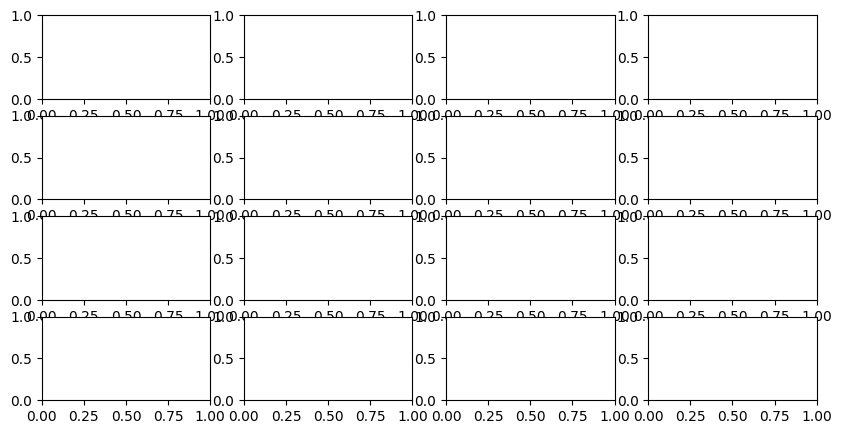

In [104]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in testing_dataset.take(2):
  images = batch["image"]
  labels = batch["label"]
  for i in range(16):
    img = (images[i] * 255).numpy().astype("uint8")
    label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
    ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
plt.show()

#print(train_dataset.take(1))
# _, ax = plt.subplots(4, 4, figsize=(10, 5))

# for batch in train_dataset.take(1):
#   images = batch["image"]
#   labels = batch["label"]
#   print("Image shape:", images.shape)
#   print("Label shape:", labels.shape)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

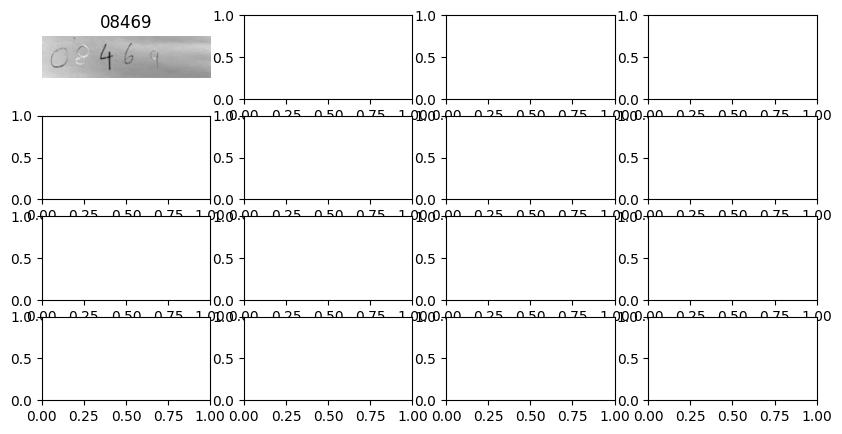

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in validation_dataset.take(1):
  images = batch["image"]
  labels = batch["label"]
  for i in range(16):
    img = (images[i] * 255).numpy().astype("uint8")
    label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
    ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
plt.show()


#MODEL


In [ ]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)

    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    )


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001)
    # Compile the model and return
    model.compile(optimizer=opt)
    return model



In [ ]:
# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

#TRAINING

In [ ]:
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)

Image shape: (16, 200, 50, 1)
Label shape: (16, 4)


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch < 10:
        return 0.001
    elif 10 <= epoch < 20:
        return 0.0001
    elif 20 <= epoch < 30:
        return 0.00001
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

epochs = 50
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping,lr_scheduler],
)

Epoch 1/50
14960/14960 [==============================] - 295s 19ms/step - loss: 7.0378 - val_loss: 6.2427 - lr: 0.0010
Epoch 2/50
14960/14960 [==============================] - 295s 20ms/step - loss: 5.3777 - val_loss: 4.1435 - lr: 0.0010
Epoch 3/50
14960/14960 [==============================] - 297s 20ms/step - loss: 2.9971 - val_loss: 1.0934 - lr: 0.0010
Epoch 4/50
14960/14960 [==============================] - 278s 19ms/step - loss: 0.7084 - val_loss: 0.2059 - lr: 0.0010
Epoch 5/50
14960/14960 [==============================] - 290s 19ms/step - loss: 0.4459 - val_loss: 0.1404 - lr: 0.0010
Epoch 6/50
14960/14960 [==============================] - 288s 19ms/step - loss: 0.3655 - val_loss: 0.1684 - lr: 0.0010
Epoch 7/50
14960/14960 [==============================] - 279s 19ms/step - loss: 0.3320 - val_loss: 0.2999 - lr: 0.0010
Epoch 8/50
14960/14960 [==============================] - 276s 18ms/step - loss: 0.3617 - val_loss: 0.1002 - lr: 0.0010
Epoch 9/50
14960/14960 [================

In [ ]:
model.save("/content/sample_data/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('my_model.keras')

In [ ]:
from google.colab import files

# Specify the file path
file_path = '/content/my_model.keras'  # Adjust the path accordingly

# Download the file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [109]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    print()
    input_shape = tf.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())
    input_length = tf.cast(input_length, tf.int32)

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [108]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

1/1 [==============================] - 2s 2s/step



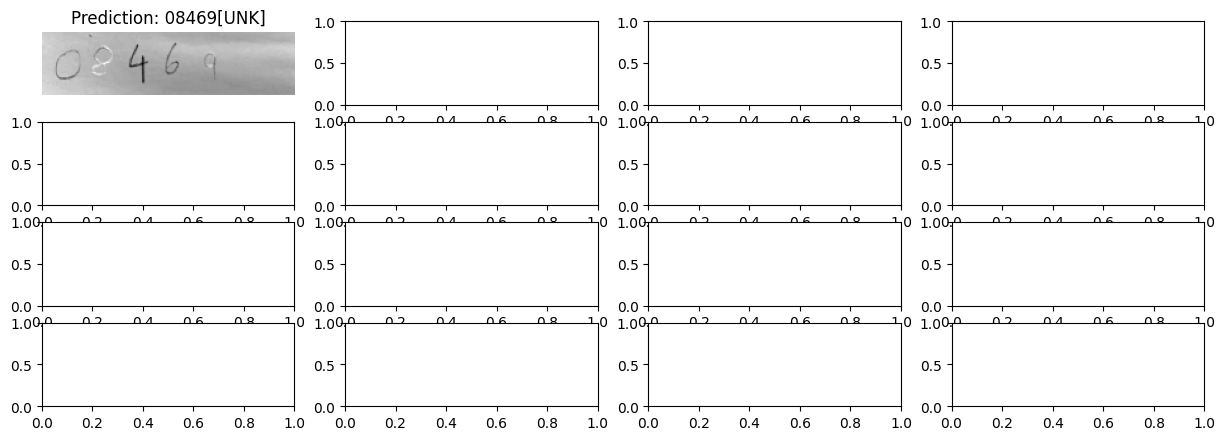

In [ ]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

#TESTING

In [ ]:
# Path to the data directory
data_dir = Path("./testing_data")
pattern = re.compile(r'_([0-9]+)_')

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

labels=[]


for old_name in images:
        # Search for the pattern in the file name
        match = pattern.search(old_name)

        # If a match is found, extract the captured substring
        if match:

            labels.append(match.group(1))
            # print(f"Renamed: {old_name} to {match.group(1)}")


print("Images :",images)
print("Labels :",labels)


Images : ['testing_data/combined_Kaustubh-1_0298_9.png', 'testing_data/combined_Kaustubh-1_0315_21.png', 'testing_data/combined_Kaustubh-1_0349_71.png', 'testing_data/combined_Kaustubh-1_0495_95.png', 'testing_data/combined_Kaustubh-1_0562_70.png', 'testing_data/combined_Kaustubh-1_0613_65.png', 'testing_data/combined_Kaustubh-1_0643_41.png', 'testing_data/combined_Kaustubh-1_0649_77.png', 'testing_data/combined_Kaustubh-1_0674_81.png', 'testing_data/combined_Kaustubh-1_0736_30.png', 'testing_data/combined_Kaustubh-1_0942_2.png', 'testing_data/combined_Kaustubh-1_0963_22.png', 'testing_data/combined_Kaustubh-1_1284_89.png', 'testing_data/combined_Kaustubh-1_1367_4.png', 'testing_data/combined_Kaustubh-1_1374_63.png', 'testing_data/combined_Kaustubh-1_1462_85.png', 'testing_data/combined_Kaustubh-1_1490_94.png', 'testing_data/combined_Kaustubh-1_1528_47.png', 'testing_data/combined_Kaustubh-1_1736_23.png', 'testing_data/combined_Kaustubh-1_1896_51.png', 'testing_data/combined_Kaustubh-1

In [8]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

model = keras.models.load_model('/content/Models/model.h5', custom_objects={'CTCLayer': CTCLayer})


In [9]:
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

1/1 [==============================] - 0s 35ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 40ms/step

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 52ms/step

1/1 [==============================] - 0s 54ms/step

1/1 [==============================] - 0s 46ms/step

1/1 [==============================] - 0s 47ms/step

1/1 [==============================] - 0s 52ms/step

1/1 [==============================] - 0s 58ms/step

1/1 [==============================] - 0s 67ms/step

1/1 [==============================] - 0s 50ms/step

1/1 [==============================] - 0s 54ms/step

1/1 [==============================] - 0s 52ms/step

1/1 [==============================] - 0s 50ms/step

1/1 [==============================] - 0s 51ms/step

1/1 [==============================] - 0s 51ms/step

1/1 [==============================] - 0s 52ms/step

1/1 [==============================] - 0s 36ms

IndexError: index 20 is out of bounds for axis 0 with size 20

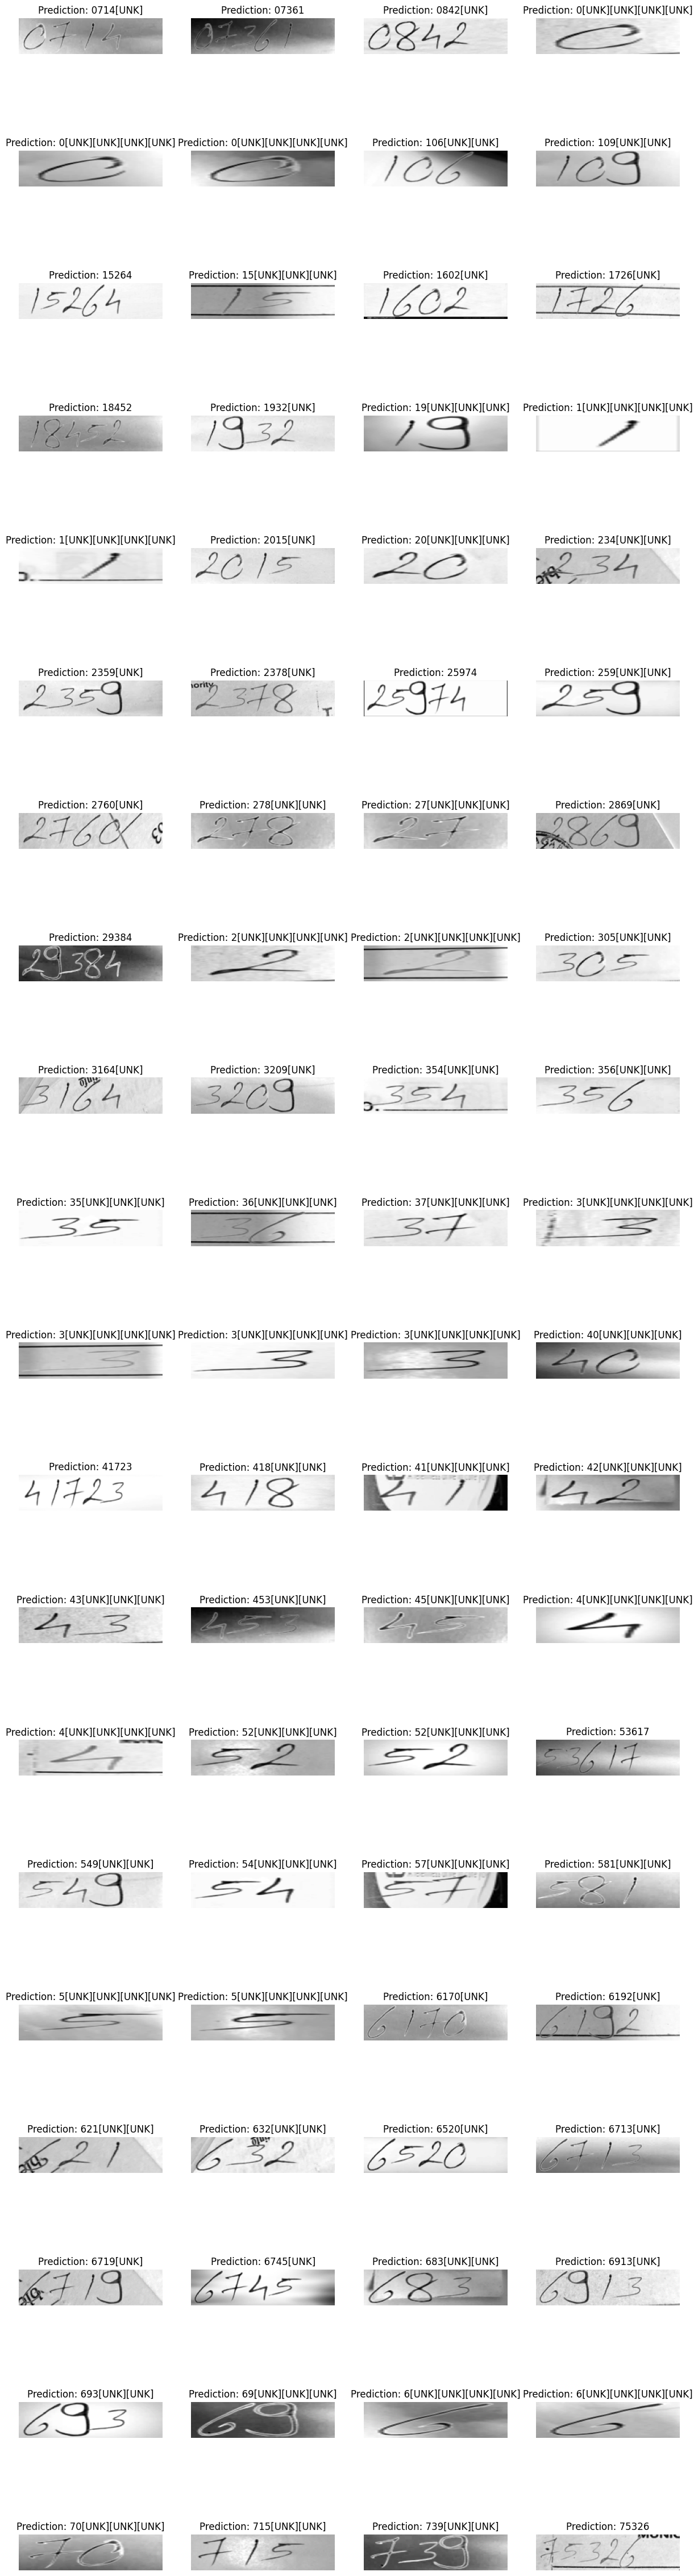

In [132]:
# for batch in testing_dataset.take(2):
#     batch_images = batch["image"]
#     batch_labels = batch["label"]

#     preds = prediction_model.predict(batch_images)
#     pred_texts = decode_batch_predictions(preds)

#     orig_texts = []
#     for label in batch_labels:
#         label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
#         orig_texts.append(label)

#     _, ax = plt.subplots(4, 4, figsize=(15, 5))
#     for i in range(len(pred_texts)):
#         img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
#         img = img.T
#         title = f"Prediction: {pred_texts[i]}"
#         ax[i // 4, i % 4].imshow(img, cmap="gray")
#         ax[i // 4, i % 4].set_title(title)
#         ax[i // 4, i % 4].axis("off")
# plt.show()

batch_size = 100
num_samples = 0

_, ax = plt.subplots(20, 4, figsize=(15,60))

for batch in testing_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[num_samples // 4, num_samples % 4].imshow(img, cmap="gray")
        ax[num_samples // 4, num_samples % 4].set_title(title)
        ax[num_samples // 4, num_samples % 4].axis("off")

        num_samples += 1
        if num_samples >= batch_size:
            break

    if num_samples >= batch_size:
        break

plt.show()
